# Create a background profile for your analysis
The background field is the first-guess field. It will be subtracted from your observations in order to work with anomalies in the analysis.      
The background field is then added to recover the original values.

In [1]:
using DIVAnd
using NCDatasets
using Statistics
using Makie, CairoMakie, GeoMakie
include("../config.jl")

"https://dox.uliege.be/index.php/s/h8d3pyqmuea6J9H/download"

We consider the salinity data in the Procençal domain

In [2]:
varname = "Salinity"

"Salinity"

Download the files (if needed) and set up domain extent and resolution.

In [3]:
obsname = salinityprovencalfile
download_check(salinityprovencalfile, salinityprovencalfileURL)
bathname = gebco04file
download_check(gebco04file, gebco04fileURL)

lonr = 3.:0.1:11.8
latr = 42.:0.1:44.5
depthr = [0.,5, 10, 15, 20, 25, 30, 40, 50, 66, 75, 85, 100, 112, 125, 135, 150, 175, 200, 
         225, 250, 275, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 
         1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1600, 1750, 1850, 2000];

bathisglobal = true
# Extract the bathymetry for plotting
bx,by,b = extract_bath(bathname,bathisglobal,lonr,latr);

[ Info: File already downloaded
[ Info: File already downloaded


## Data reading

In [4]:
obsvalue, obslon, obslat, obsdepth, obstime, obsids = DIVAnd.loadobs(Float64, obsname, varname);

### Exclude some outliers
We provide a list of identifiers corresponding to bad measurements, and also restrict the salinity value in the internal 37.6 - 38.75.

In [5]:
badid = ["wod_015600782O","wod_015602753O","wod_015604717O","wod_015606732O","wod_015607117O",
         "wod_015607524O","wod_015607893O","wod_015924970O","wod_015926914O","wod_015928739O",
         "wod_016650545O","wod_008518725O","wod_007643915O","wod_015875365O","wod_006614816O",
         "wod_006614929O","wod_006614937O","wod_007644875O","wod_009996947O","wod_010742471O",
         "wod_010742472O","wod_006614931O","wod_006614934O","wod_006625408O","wod_006752127O",
         "wod_006752129O"]

good = (37.6 .< obsvalue .< 38.75) .& map(id -> !(id in badid),obsids)

obsvalue = obsvalue[good]
obslon = obslon[good]
obslat = obslat[good]
obsdepth = obsdepth[good]
obstime = obstime[good]
obsids = obsids[good];

Verify the data range

In [6]:
DIVAnd.checkobs((obslon, obslat, obsdepth, obstime),obsvalue,obsids)

[ Info: Checking ranges for dimensions and observations


              minimum and maximum of obs. dimension 1: (3.0418334007263184, 11.8100004196167)
              minimum and maximum of obs. dimension 2: (42.0, 44.0)
              minimum and maximum of obs. dimension 3: (-0.0, 2762.0)
              minimum and maximum of obs. dimension 4: (Dates.DateTime("1892-09-25T00:00:00"), Dates.DateTime("2017-10-02T06:14:02.761"))
                          minimum and maximum of data: (37.600101470947266, 38.74980163574219)


## Prepare background

We make a seasonal profile for all data within 1950 and 2017

In [7]:
yearlist = [1950:2017]

# winter: January-March    1,2,3
# spring: April-June       4,5,6
# summer: July-September   7,8,9
# autumn: October-December 10,11,12

monthlists = [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]];

TS = DIVAnd.TimeSelectorYearListMonthList(yearlist, monthlists)

epsilon2 = ones(size(obsvalue));

In [8]:
?DIVAnd.average_background_profile

!!! warning
    The following bindings may be internal; they may change or be removed in future versions:

      * `DIVAnd.average_background_profile`


```
average_background_profile(
background_filename, (lonr,latr,depthr,TS), (obslon, obslat, obsdepth, obstime), obsvalue,
epsilon2,
varname;
transform = DIVAnd.Anam.notransform(),
searchz = background_profile_searchz(depthr),
```

Compute the average background profile by averaging the observations within a distance given by `searchz` and for each time instance defined in the time selector `TS`.


### Create the background

In [9]:
background_filename = joinpath(outputdir, "average_background_profile_$(varname).nc")

if isfile(background_filename)
    rm(background_filename)
end

DIVAnd.average_background_profile(
    background_filename, (lonr,latr,depthr,TS), (obslon, obslat, obsdepth, obstime), obsvalue,
    epsilon2,
    varname)

[ Info: Time step 1 / 4
[ Info: Time step 2 / 4
[ Info: Time step 3 / 4
[ Info: Time step 4 / 4


### Plot the salinity profile

In [10]:
ds = Dataset(background_filename)
S = ds["Salinity"][1,1,:,:]
close(ds)

closed Dataset

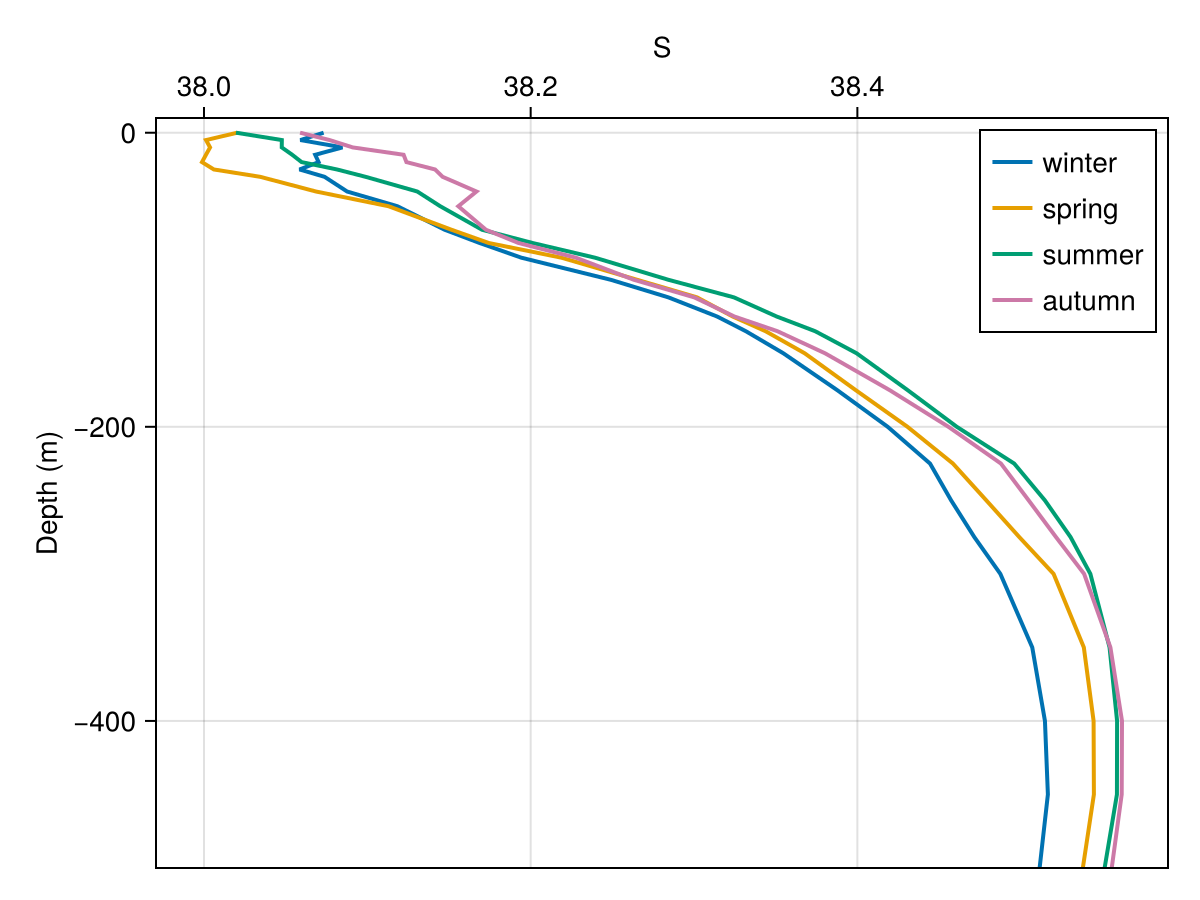

In [11]:
f = Figure()
ax = Axis(f[1,1], ylabel="Depth (m)", xlabel="S", xaxisposition=:top)
seasons = ["winter","spring","summer","autumn"]
for n = 1:length(seasons)
    lines!(ax, S[:,n],-depthr,label=seasons[n], linewidth=2)
end
axislegend();
ylims!(-500, 10)
f

### Plot the observations

In [12]:
sel = DIVAnd.select(TS,2,obstime) .& (obsdepth .< 5);

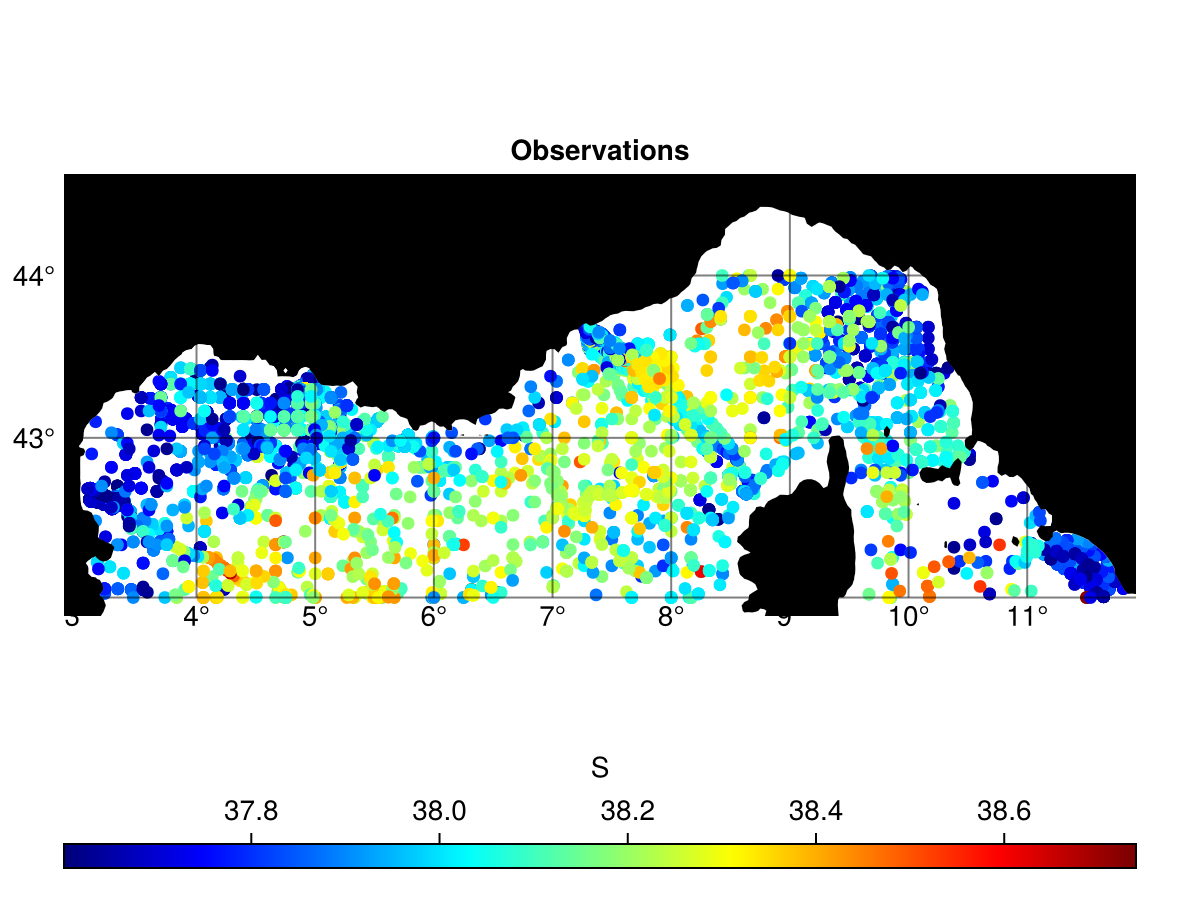

In [13]:
fig = Figure()
ga = GeoAxis(fig[1,1];  dest = "+proj=merc", xticks=2.:1.:14, yticks=42.:1.:45., title="Observations")
sc = scatter!(ga, obslon[sel], obslat[sel], color=obsvalue[sel], colormap=:jet)
contourf!(ga, bx, by, b, levels=[-1e5,0, 1.], colormap=Reverse(:binary))
xlims!(bx[1], bx[end])
ylims!(by[1], by[end])
Colorbar(fig[2, 1], sc, vertical = false, label = "S")
fig

The vertical average is controled by a parameter `searchz` defined using the vertical resolution. `searchz` is a list of tuples where every tuple composed by an upper and lower bound.

In [14]:
searchz = DIVAnd.background_profile_searchz(depthr);

The surface value is this the average between 0 and 2.5 meters. Let's check:

In [15]:
sel = DIVAnd.select(TS,1,obstime) .& (0 .<= obsdepth .<= 2.5);
@show mean(obsvalue[sel])
@show S[1,1];

mean(obsvalue[sel]) = 38.07323237632587
S[1, 1] = 38.07323f0


Additional smoothing by increasing the value of the optional argument factor

In [16]:
searchz = DIVAnd.background_profile_searchz(depthr, factor=3);

In [17]:
background_filename2 = joinpath(outputdir, "average_background_profile2_$(varname).nc")

if isfile(background_filename2)
    rm(background_filename2)
end

DIVAnd.average_background_profile(
    background_filename2, (lonr,latr,depthr,TS), (obslon, obslat, obsdepth, obstime), obsvalue,
    epsilon2,
    varname, searchz = searchz)

[ Info: Time step 1 / 4
[ Info: Time step 2 / 4
[ Info: Time step 3 / 4
[ Info: Time step 4 / 4


### Plot the seasonal profiles

In [18]:
ds = Dataset(background_filename2)
S2 = ds["Salinity"][1,1,:,:]
close(ds)

closed Dataset

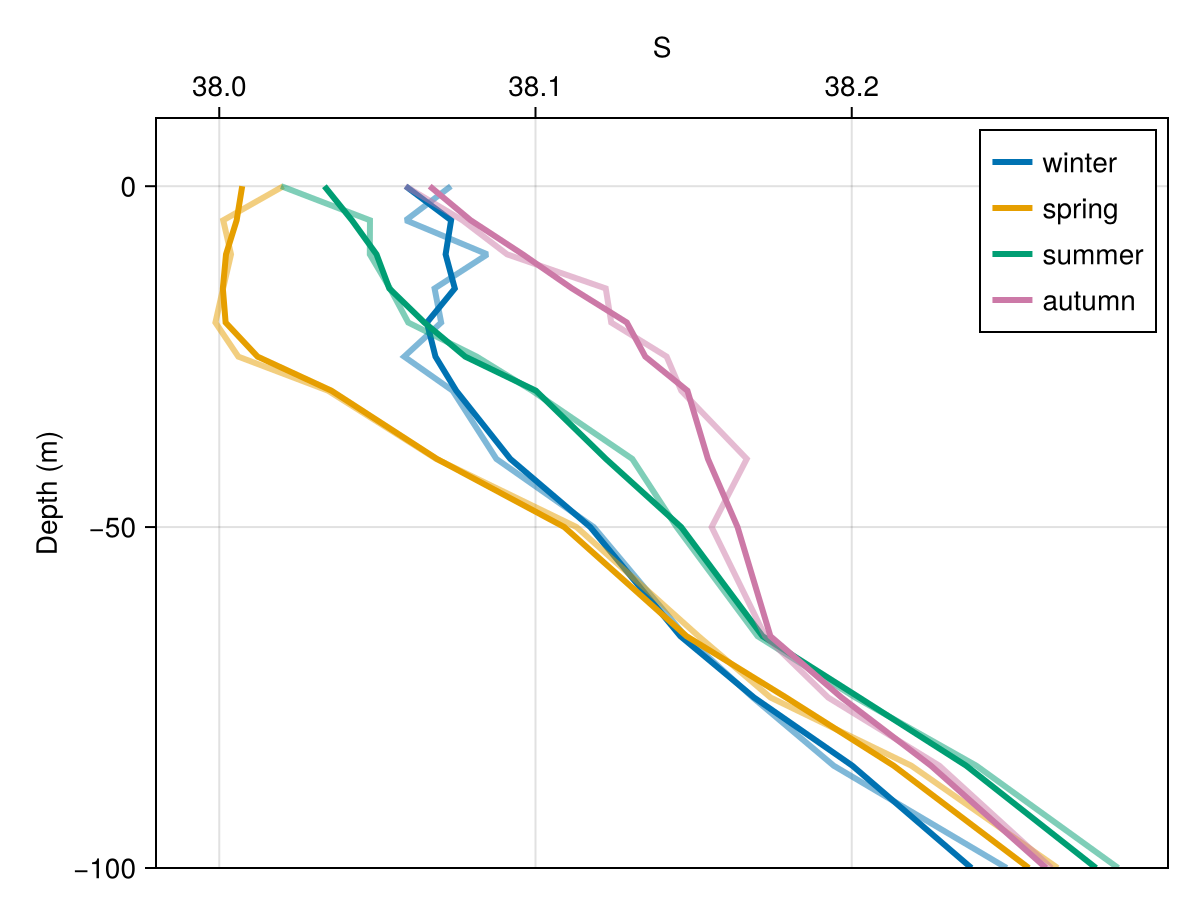

In [19]:
f = Figure()
ax = Axis(f[1,1], ylabel="Depth (m)", xlabel="S", xaxisposition=:top)
for n = 1:length(seasons)
    line1 = lines!(ax, S2[:,n],-depthr,label=seasons[n], linewidth=3)
    lines!(ax, S[:,n],-depthr, color=line1.color, linewidth=3, alpha=.5)
end
axislegend();
ylims!(-100, 10)
xlims!(37.98, 38.3)
f

## Exercise
* Comment-out the quality check in the beginning and redo the other plots
* Compare the results